In [ ]:
"""
04_EDA.ipynb

This notebook performs Exploratory Data Analysis (EDA) on the cleaned dataset.

Key steps:
- Distribution of continuous features
- Correlation analysis
- WHO thresholds visualization on key features
- Outlier detection (Mahalanobis, Isolation Forest, LOF)
- Binning of important features
- Create USS
- Clinical relevance annotation

Outputs:
- Cleaned, annotated dataset saved for modeling
- Visual insights
"""


'\n04_EDA.ipynb\n\nThis notebook performs Exploratory Data Analysis (EDA) on the cleaned dataset.\n\nKey steps:\n- Distribution and skewness of continuous features\n- Correlation analysis (Pearson, Spearman)\n- WHO thresholds visualization on key features\n- Outlier detection (Mahalanobis, Isolation Forest, LOF)\n- Binning of important features\n- Clinical relevance annotation\n\nOutputs:\n- Cleaned, annotated dataset saved for Feature Engineering\n- Visual insights\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew
import statsmodels.api as sm
from scipy.stats import chi2
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# ==============================
# 1. Load Data and Inspect
# ==============================

In [29]:
data = pd.read_pickle('03_cleaned_data.pkl')
test_data = pd.read_pickle('03_cleaned_test_data.pkl')

In [ ]:
# ==============================
# 2. Continuous Feature Distribution & Skewness
# ==============================

In [30]:
continuous_target_features = ['DFI', 'TUNEL']
continuous_features = ['Semen Volume', 'Sperm Concentration', 'Total Motility', 'Progressive Motility',
                 'Non-progressive Motility', 'Immotile Sperm', 'Abnormal Morphology','Age', 'Sperm Count','TMS']

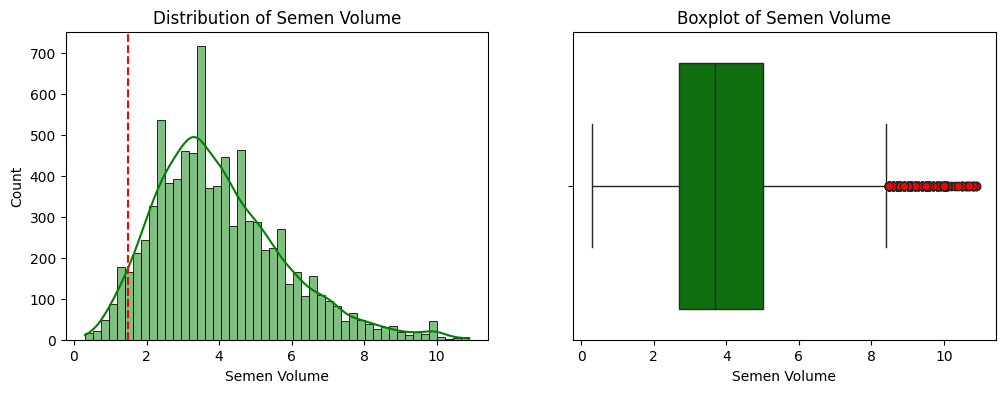

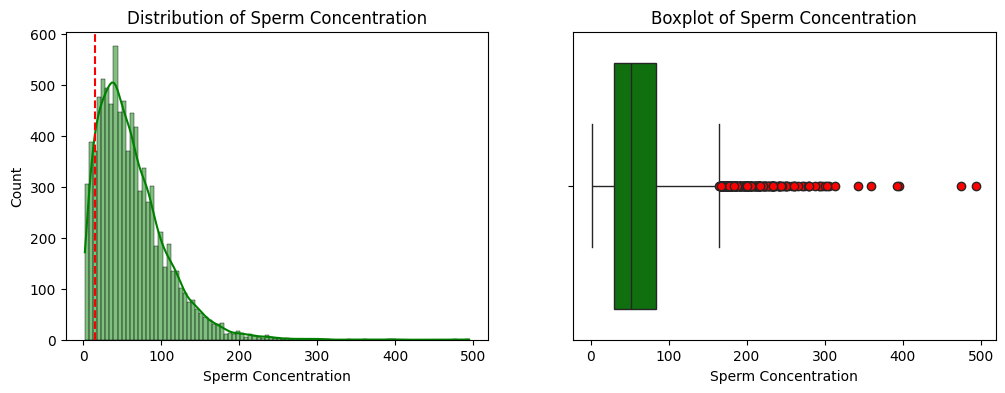

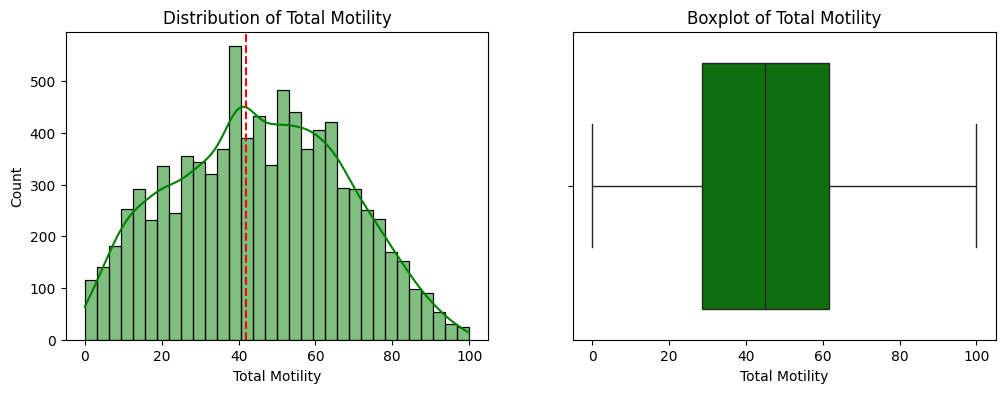

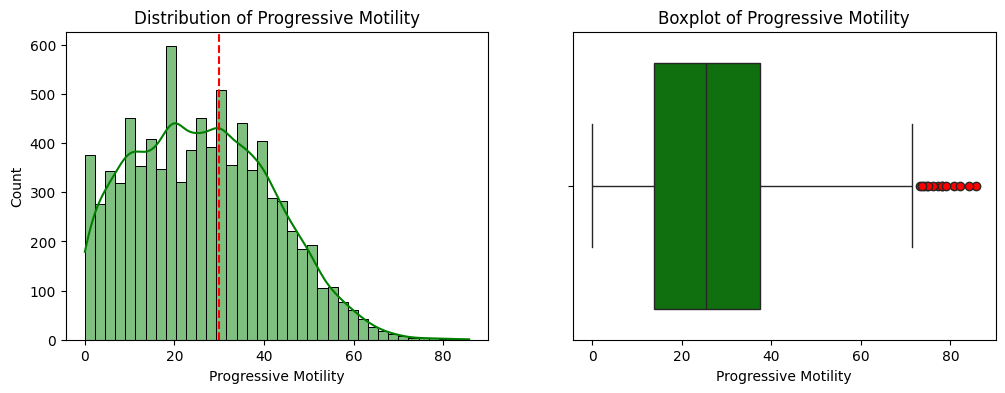

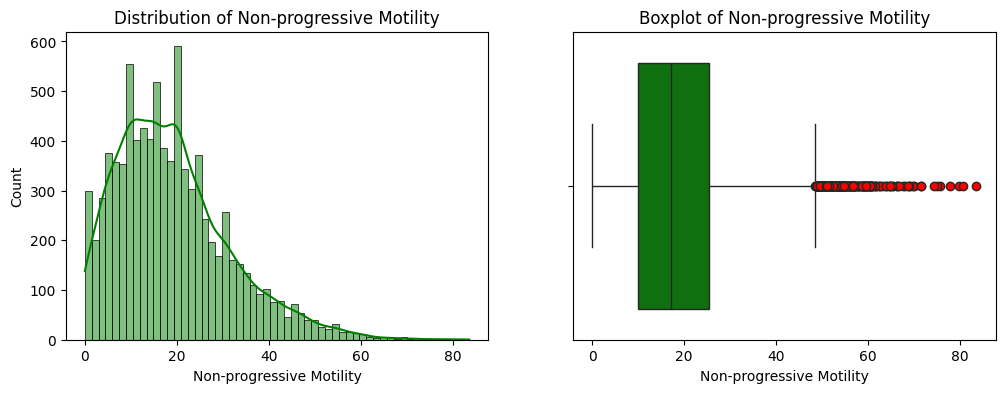

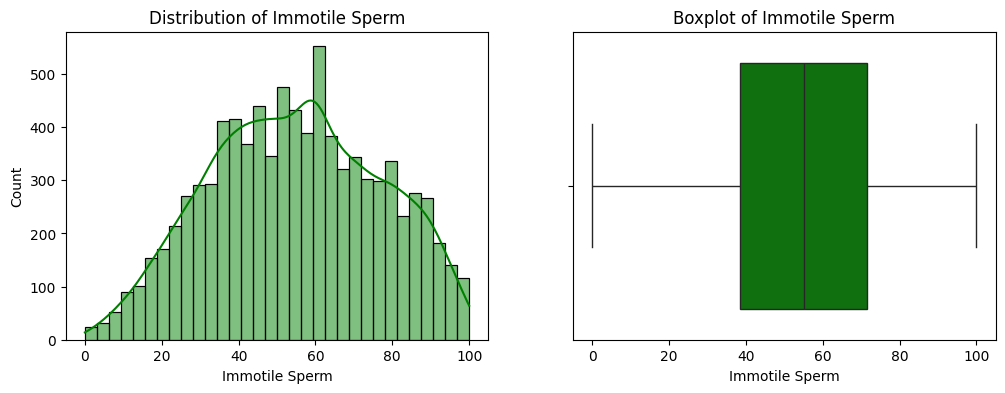

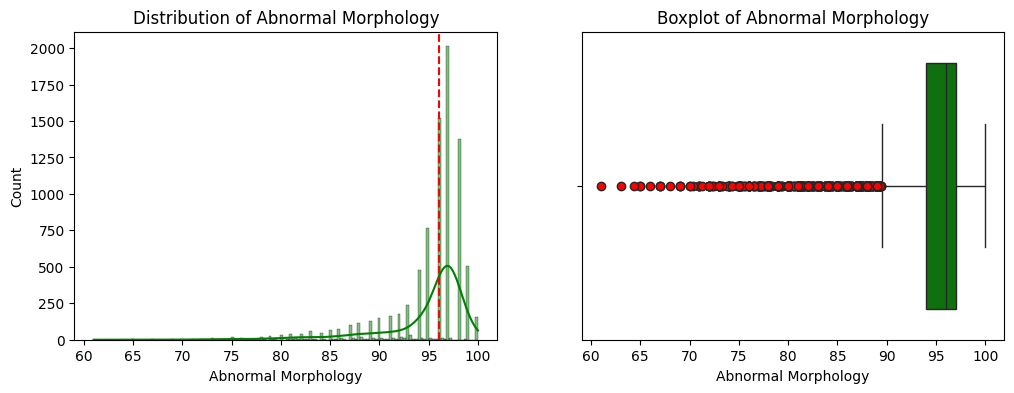

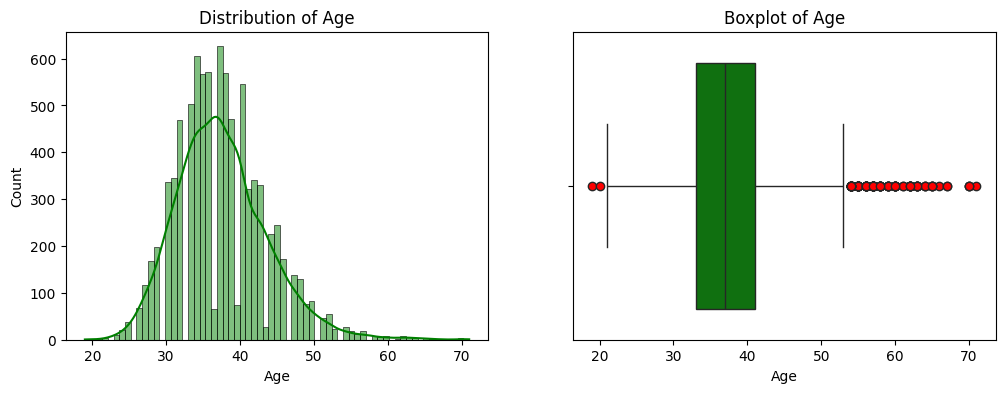

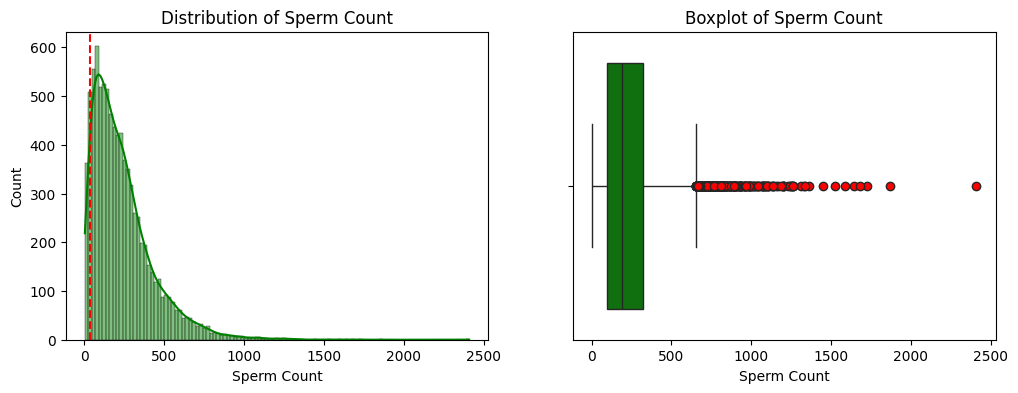

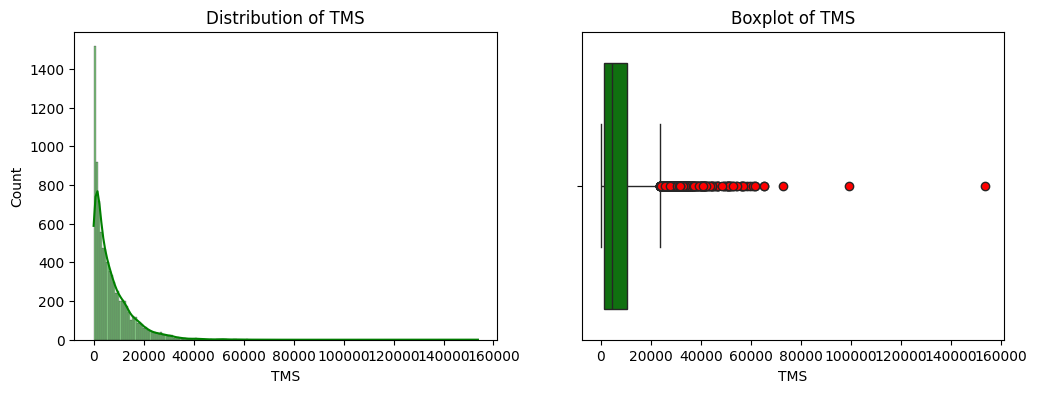

In [31]:
# Histogram and KDE for continuous features
for col in continuous_features:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, color='green')
    plt.title(f'Distribution of {col}')

    if col == 'Semen Volume':
      plt.axvline(x=1.5, color='red', linestyle='--', label='WHO Threshold')
    elif col == 'Sperm Concentration':
      plt.axvline(x=15, color='red', linestyle='--', label='WHO Threshold')
    elif col == 'Total Motility':
      plt.axvline(x=42, color='red', linestyle='--', label='WHO Threshold')
    elif col == 'Progressive Motility':
      plt.axvline(x=30, color='red', linestyle='--', label='WHO Threshold')
    elif col == 'Abnormal Morphology':
      plt.axvline(x=96, color='red', linestyle='--', label='WHO Threshold')
    elif col == 'Sperm Count':
      plt.axvline(x=39, color='red', linestyle='--', label='WHO Threshold')


    # Box plots to check for outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, x=data[col],color='green', flierprops=dict(marker='o', markerfacecolor='r', markersize=6, linestyle='none'))
    plt.title(f'Boxplot of {col}')

    plt.show()

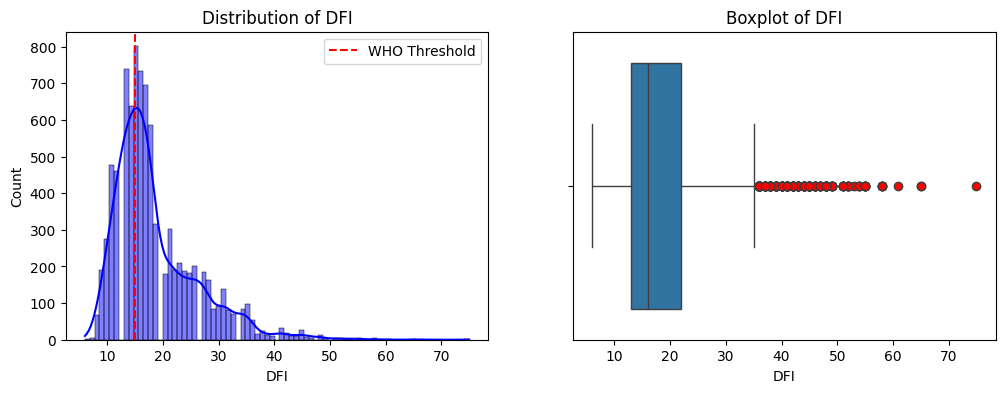

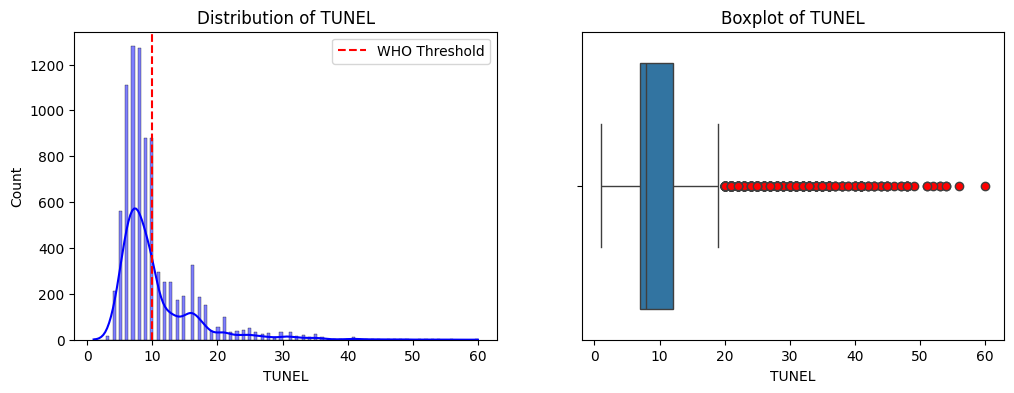

In [6]:
# continuous target variables
for col in continuous_target_features:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, color='blue')
    plt.axvline(x=15 if col == 'DFI' else 10, color='red', linestyle='--', label='WHO Threshold')
    plt.title(f'Distribution of {col}')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, x=data[col], flierprops=dict(marker='o', markerfacecolor='r', markersize=6, linestyle='none'))
    plt.title(f'Boxplot of {col}')
    plt.show()

In [ ]:
# ==============================
# 3. Correlation Analysis
# ==============================

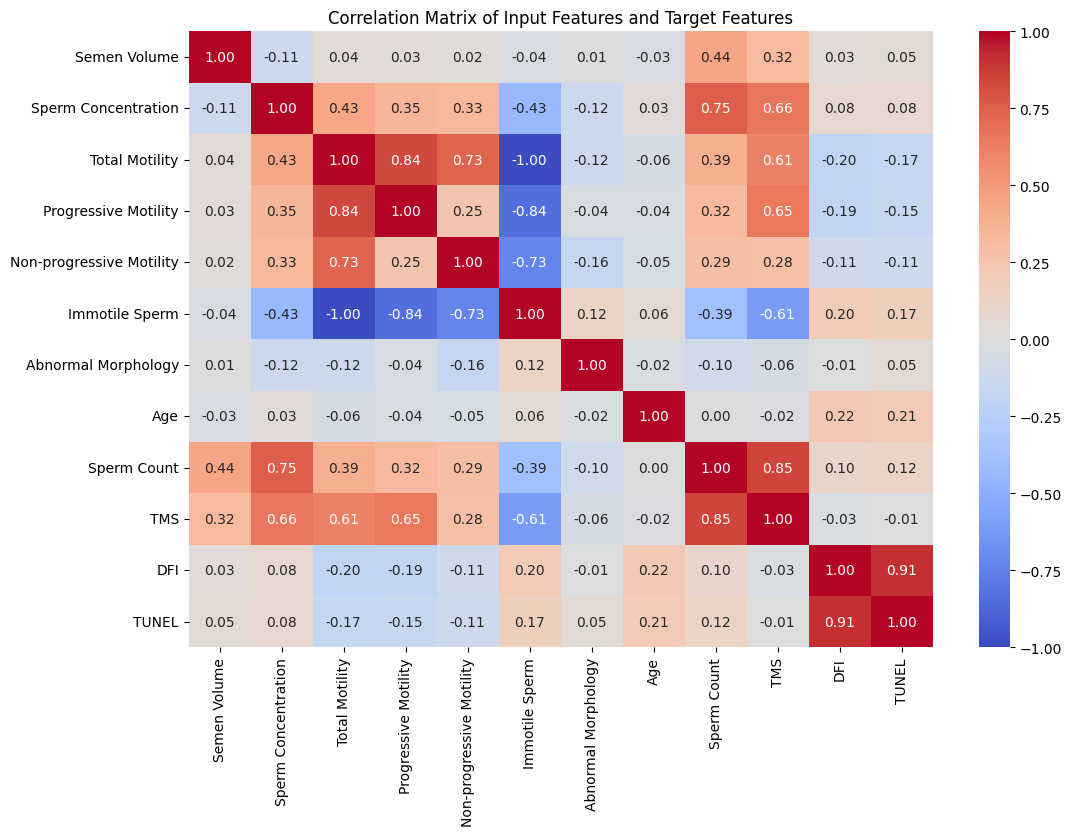

In [32]:
# Calculate correlations
correlation_matrix = data[continuous_features + continuous_target_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Input Features and Target Features')
plt.show()

In [ ]:
# ==============================
# 4. Outlier Detection
# ==============================

In [33]:
#mahalanobis distance outliers
def MD(df, mu, cov):
    diff = df - mu
    inv_cov = np.linalg.pinv(cov)
    mahal = np.dot(np.dot(diff, inv_cov), diff.T)
    return np.sqrt(np.maximum(mahal.diagonal(), 0))  # avoid negative values

# calculate mean vector and covariance matrix
mu = data[continuous_features].mean().values
cov = np.cov(data[continuous_features].values, rowvar=False)

# Compute Mahalanobis distance
data['Mahal_dist'] = MD(data[continuous_features], mu, cov)

# chi-squared distribution with 97.5% confidence
threshold = chi2.ppf((1 - 0.025), data[continuous_features].shape[1])  # Adjust for feature count

# Flag data points as outliers
data['MD_outlier'] = data['Mahal_dist'] > np.sqrt(threshold)

In [34]:
#Isolation forest outliers
def IF(data):
    iso_forest = IsolationForest(contamination=0.05)  # 5% contamination level
    y_pred = iso_forest.fit_predict(data)
    return y_pred == -1  # -1 means outlier

# Apply Isolation Forest Method
data['IF_outlier'] = IF(data[continuous_features])

In [35]:
# local outlier factor

# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Fit the model and get the LOF outlier predictions (-1 for outliers, 1 for inliers)
outliers = lof.fit_predict(data[continuous_features])

data['LOF_outlier'] = outliers == -1  # True if outlier, False if normal

In [37]:
data['Common_outlier'] = (data['MD_outlier'] & data['IF_outlier'] & data['LOF_outlier'] )

In [38]:
# Check how many outliers each method detected
print(data[['MD_outlier','IF_outlier','LOF_outlier','Common_outlier']].sum())

MD_outlier        489
IF_outlier        436
LOF_outlier       436
Common_outlier    106
dtype: int64


In [13]:
def summary_stats(data, outlier_col):
    # Filter data without outliers
    data_without_outliers = data[~data[outlier_col]]

    numeric_data = data_without_outliers.select_dtypes(include=['float64', 'int64'])

    # Calculate summary statistics
    stats = {
        'Mean': numeric_data.mean(),
        'Median': numeric_data.median(),
        'Range': numeric_data.max() - numeric_data.min()  # Only for numeric columns
    }
    return pd.DataFrame(stats)

# Compare summary statistics for each outlier detection method
methods = ['MD_outlier', 'IF_outlier', 'LOF_outlier', 'Common_outlier']

# Initialize a dictionary to store results
results = {}

data1 = data.drop(columns=['DFI', 'TUNEL', 'Mahal_dist'])

# Calculate summary statistics for each method
for method in methods:
    print(f"Summary Statistics Without {method} Outliers:")
    stats = summary_stats(data1, method)
    results[method] = stats
    print(stats)
    print("\n")

# Compare with overall summary statistics
print("Overall Summary Statistics (With All Data):")
numeric_data_all = data1.select_dtypes(include=['float64', 'int64'])  # Only numeric columns
overall_stats = {
    'Mean': numeric_data_all.mean(),
    'Median': numeric_data_all.median(),
    'Range': numeric_data_all.max() - numeric_data_all.min()  # Only for numeric columns
}
print(pd.DataFrame(overall_stats))

Summary Statistics Without MD_outlier Outliers:
                                 Mean   Median    Range
Semen Volume                 3.932587     3.70     10.6
Sperm Concentration         58.347103    51.00    227.0
Total Motility              44.863224    45.00    100.0
Progressive Motility        26.186458    25.50     76.1
Non-progressive Motility    18.676766    17.00     68.0
Immotile Sperm              55.136776    55.00    100.0
Abnormal Morphology         95.108460    96.00     25.0
Age                         37.392512    37.00     44.0
Sperm Count                221.768216   186.90    953.8
TMS                       6700.275668  4445.55  37260.0


Summary Statistics Without IF_outlier Outliers:
                                 Mean   Median     Range
Semen Volume                 3.945675     3.70     10.60
Sperm Concentration         57.937737    50.00    298.00
Total Motility              44.010580    44.40     96.50
Progressive Motility        25.793367    25.00     84.20
N

In [ ]:
# ==============================
# 5. Binning and Feature Categorization
# ==============================

In [39]:
# Create Bin-specific features based on WHO thresholds
data['Semen Volume Binned'] = pd.cut(data['Semen Volume'],
                                      bins=[data['Semen Volume'].min()-1, 1.5, data['Semen Volume'].max()],
                                      labels=['Abnormal', 'Normal'])
test_data['Semen Volume Binned'] = pd.cut(test_data['Semen Volume'],
                                      bins=[test_data['Semen Volume'].min()-1, 1.5, test_data['Semen Volume'].max()],
                                      labels=['Abnormal', 'Normal'])

data['Sperm Concentration Binned'] = pd.cut(data['Sperm Concentration'],
                                             bins=[data['Sperm Concentration'].min()-1, 15, data['Sperm Concentration'].max()],
                                             labels=['Abnormal', 'Normal'])
test_data['Sperm Concentration Binned'] = pd.cut(test_data['Sperm Concentration'],
                                             bins=[test_data['Sperm Concentration'].min()-1, 15, test_data['Sperm Concentration'].max()],
                                             labels=['Abnormal', 'Normal'])


data['Total Motility Binned'] = pd.cut(data['Total Motility'],
                                        bins=[data['Total Motility'].min()-1, 42, data['Total Motility'].max()],
                                        labels=['Abnormal', 'Normal'])
test_data['Total Motility Binned'] = pd.cut(test_data['Total Motility'],
                                        bins=[test_data['Total Motility'].min()-1, 42, test_data['Total Motility'].max()],
                                        labels=['Abnormal', 'Normal'])


data['Progressive Motility Binned'] = pd.cut(data['Progressive Motility'],
                                              bins=[data['Progressive Motility'].min()-1, 30, data['Progressive Motility'].max()],
                                              labels=['Abnormal', 'Normal'])
test_data['Progressive Motility Binned'] = pd.cut(test_data['Progressive Motility'],
                                              bins=[test_data['Progressive Motility'].min()-1, 30, test_data['Progressive Motility'].max()],
                                              labels=['Abnormal', 'Normal'])


data['Abnormal Morphology Binned'] = pd.cut(data['Abnormal Morphology'],
                                             bins=[data['Abnormal Morphology'].min()-1, 96, data['Abnormal Morphology'].max()],
                                             labels=['Normal','Abnormal'])
test_data['Abnormal Morphology Binned'] = pd.cut(test_data['Abnormal Morphology'],
                                             bins=[test_data['Abnormal Morphology'].min()-1, 96, test_data['Abnormal Morphology'].max()],
                                             labels=['Normal','Abnormal'])


data['Sperm Count Binned'] =  pd.cut(data['Sperm Count'],
                                      bins=[data['Sperm Count'].min()-1, 39, data['Sperm Count'].max()],
                                      labels=['Abnormal', 'Normal'])
test_data['Sperm Count Binned'] =  pd.cut(test_data['Sperm Count'],
                                      bins=[test_data['Sperm Count'].min()-1, 39, test_data['Sperm Count'].max()],
                                      labels=['Abnormal', 'Normal'])

In [ ]:
# ==============================
# 6. Create USS
# ==============================

In [40]:
# unhealthy sperm score (USS)
data['Sperm_Dysfunction_Proxy'] = (data['Immotile Sperm'] * data['Age'])**2 * (data['Abnormal Morphology']) * (data['Sperm Count']**0.5)
test_data['Sperm_Dysfunction_Proxy'] = (test_data['Immotile Sperm'] * test_data['Age'])**2 * (test_data['Abnormal Morphology']) * (test_data['Sperm Count']**0.5)

data['USS'] = MinMaxScaler().fit_transform(data[['Sperm_Dysfunction_Proxy']])*100
test_data['USS'] = MinMaxScaler().fit_transform(test_data[['Sperm_Dysfunction_Proxy']])*100

data.drop(columns='Sperm_Dysfunction_Proxy',inplace=True)
test_data.drop(columns='Sperm_Dysfunction_Proxy',inplace=True)

In [ ]:
# ==============================
# 7. Save EDA Output
# ==============================

In [41]:
#drop unnecessary features
data.drop(columns=['MD_outlier', 'IF_outlier', 'LOF_outlier', 'Common_outlier','Mahal_dist'], inplace=True)

In [42]:
print(f"✅ Final data shape after EDA: {data.shape}")
print(f"✅ Final test data shape after EDA: {test_data.shape}")

✅ Final data shape after EDA: (8716, 19)
✅ Final test data shape after EDA: (1000, 19)


In [43]:
# Save analyzed data
data.to_pickle('04_analyzed_data.pkl')
test_data.to_pickle('04_analyzed_test_data.pkl')